# **Упражнение 4.1**

На сайте Soft Murmur можно послушать множество природных источников шума, включая дождь, волны, ветер и др. На веб-странице [http://asoftmurmur.com/about/](http://asoftmurmur.com/about/) приведен перечень записей; большинство из них хранится на [http://freesound.org](http://freesound.org).

Скачайте некоторые из этих файлов и вычислите спектры каждого сигнала. Похож ли их спектр мощности на белый, розовый или броуновский шум? Как спектр меняется во времени?

**Ход работы**

In [8]:
import os
!pip install wget
if not os.path.exists('thinkdsp.py'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from thinkdsp import Spectrum, Wave, Noise
from thinkdsp import decorate, read_wave, unbias, normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if not os.path.exists('crickets.wav'):
    !python -m wget https://github.com/timatifey/spbstu-telecom-labs-2022/raw/main/chap04/crickets.wav

if not os.path.exists('tibetan-bowls.wav'):
    !python -m wget https://github.com/timatifey/spbstu-telecom-labs-2022/raw/main/chap04/tibetan-bowls.wav

if not os.path.exists('rain.wav'):
    !python -m wget https://github.com/timatifey/spbstu-telecom-labs-2022/raw/main/chap04/rain.wav

if not os.path.exists('bitstampUSD.csv'):
    !python -m wget https://github.com/timatifey/spbstu-telecom-labs-2022/raw/main/chap04/bitstampUSD.csv

Проанализируем спектры звуков: треск сверчков, дождя и тибетских чаш.

## Звук дождя

In [9]:
rain_segment = read_wave('rain.wav').segment(start=2.0, duration=1.0)
rain_segment.make_audio()

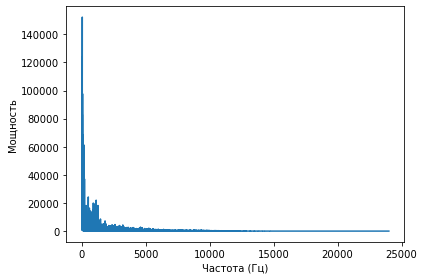

In [10]:
rain_spectrum = rain_segment.make_spectrum()
rain_spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность')

По графику видно, что амплитуда падает с увеличением частоты, что означает, что это красный или розовый шум. Далее посмотрим на спектр мощности в логарифмической шкале.

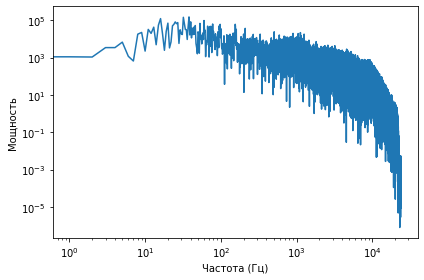

In [11]:
rain_spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [12]:
rain_spectrum.estimate_slope().slope

-2.9829301737076066

Глядя на данный график можно сказать, что это красный шум, но рассмотрим дополнительно еще один сегмент ради интереса.

In [13]:
rain_segment2 = read_wave('rain.wav').segment(start=6.0, duration=1.0)
rain_segment2.make_audio()

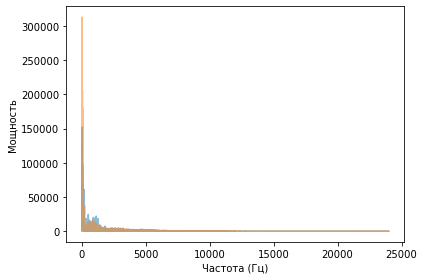

In [14]:
rain_spectrum2 = rain_segment2.make_spectrum()
rain_spectrum.plot_power(alpha=0.5)
rain_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частота (Гц)', ylabel='Мощность')

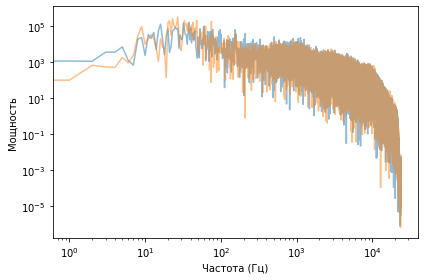

In [15]:
rain_spectrum.plot_power(alpha=0.5)
rain_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [16]:
rain_spectrum2.estimate_slope().slope

-2.8308545237815106

Это похоже на красный шум.

## Треск сверчков

In [17]:
crickets_segment = read_wave('crickets.wav').segment(start=2.0, duration=1.0)
crickets_segment.make_audio()

In [18]:
crickets_segment2 = read_wave('crickets.wav').segment(start=6.0, duration=1.0)
crickets_segment2.make_audio()

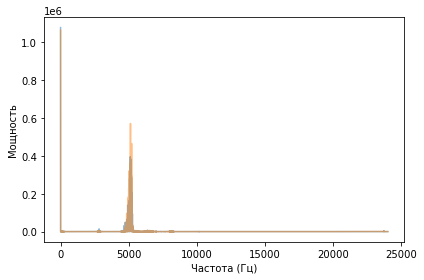

In [19]:
crickets_spectrum = crickets_segment.make_spectrum()
crickets_spectrum2 = crickets_segment2.make_spectrum()
crickets_spectrum.plot_power(alpha=0.5)
crickets_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частота (Гц)', ylabel='Мощность')

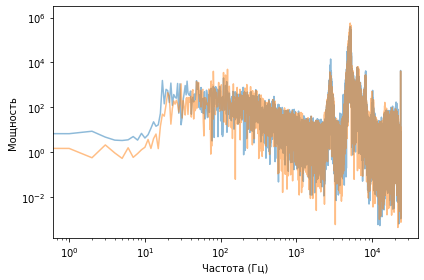

In [20]:
crickets_spectrum.plot_power(alpha=0.5)
crickets_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [21]:
crickets_spectrum.estimate_slope().slope

-0.7241040051452777

In [22]:
crickets_spectrum2.estimate_slope().slope

-0.6988615083549293

Точно определить тип шума возникают трудности. Однако это больше всего похоже на розовый шум.

## Тибетские чаши

In [23]:
bowls_segment = read_wave('tibetan-bowls.wav').segment(start=2.0, duration=1.0)
bowls_segment.make_audio()

In [24]:
bowls_segment2 = read_wave('tibetan-bowls.wav').segment(start=6.0, duration=1.0)
bowls_segment2.make_audio()

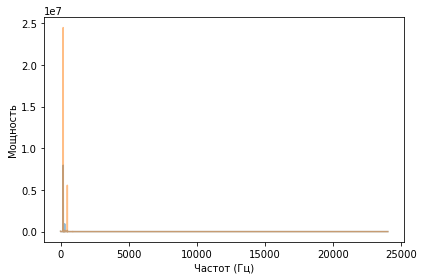

In [25]:
bowls_spectrum = bowls_segment.make_spectrum()
bowls_spectrum2 = bowls_segment2.make_spectrum()
bowls_spectrum.plot_power(alpha=0.5)
bowls_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частот (Гц)', ylabel='Мощность')

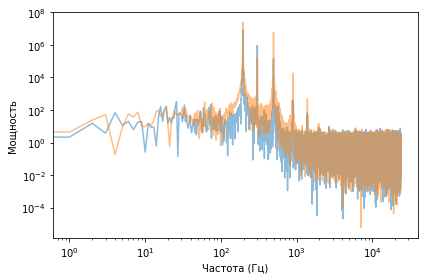

In [26]:
bowls_spectrum.plot_power(alpha=0.5)
bowls_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [27]:
bowls_spectrum.estimate_slope().slope

-0.45345391916271116

In [28]:
bowls_spectrum2.estimate_slope().slope

-0.728832891460207

Делаем вывод, что это розовый шум.

# **Упражнение 4.2**

В шумовом сигнале частотный состав меняется во времени. На большом интервале мощность на всех частотах одинакова, а на коротком мощность на каждой частоте случайна.

Для оценки долговременной средней мощности на каждой частоте можно разорвать сигнал на сегменты, вычислить спектр мощности для каждого сегмента, а затем найти среднее по сегментам.

Реализуйте метод Бартлетта и используйте его для оценки спектра мощности шумового сигнала. Подсказка: посмотрите на реализацию *make_spectrogram*.

**Ход работы**
Код метода Бартлетта представлен ниже

In [29]:
def bartlett_method(wave, seg_length=512, win_flag=True):
    spectrum = wave.make_spectrogram(seg_length, win_flag)
    segments = spectrum.spec_map.values()

    power_segments = []
    for segment in segments:
        power_segments.append(segment.power)
  
    hs = np.sqrt(sum(power_segments)/len(power_segments))
    fs = next(iter(segments)).fs

    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

Исследуем работу алгоритма на используемых выше сегментах.

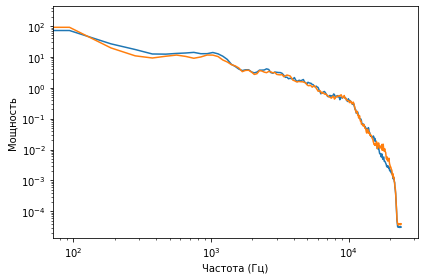

In [30]:
rain_res = bartlett_method(rain_segment)
rain_res2 = bartlett_method(rain_segment2)

crickets_res = bartlett_method(crickets_segment)
crickets_res2 = bartlett_method(crickets_segment2)

bowls_res = bartlett_method(bowls_segment)
bowls_res2 = bartlett_method(bowls_segment2)

rain_res.plot_power()
rain_res2.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

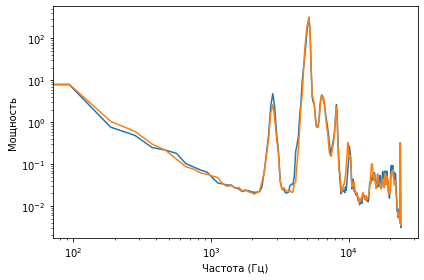

In [31]:
crickets_res.plot_power()
crickets_res2.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

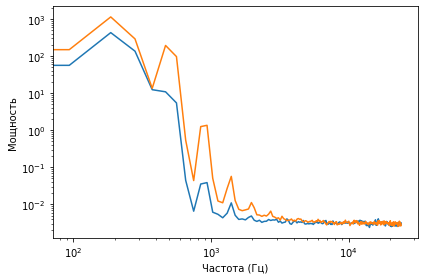

In [32]:
bowls_res.plot_power()
bowls_res2.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

С помощью данного метод мы можем видеть зависимость между частотами и мощностью более чётче. На основе новых графиков можно заметить, что предположения из предыдущего управжения оправдались.

# **Упражнение 4.3**

На веб-странице [http://www.coindesk.com/price](http://www.coindesk.com/price) можно скачать в ввиде CSV-файла исторические данные о ежедневной цене BitCoin. Откройте этот файл и вычислите спектр цен BitCoin как функцию времени. Похоже ли это на белый, розовый или броуновский шум?

**Ход работы**

In [33]:
data = pd.read_csv('bitstampUSD.csv')
data

,Timestamp,Weighted_Price
0,1325317920,4.390000
1,1325346600,4.390000
2,1325350740,4.526411
3,1325350800,4.580000
4,1325391360,4.580000
...,...,...
3613764,1617148560,58692.753339
3613765,1617148620,58693.226508
3613766,1617148680,58696.198496
3613767,1617148740,58761.866202


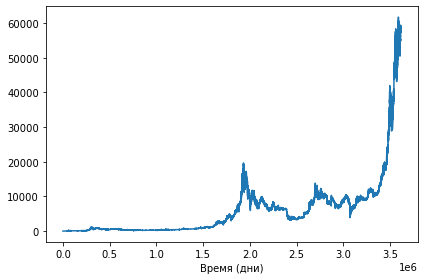

In [34]:
btc_wave = Wave(data['Weighted_Price'], data.index, framerate = 1)
btc_wave.plot()
decorate(xlabel='Время (дни)')

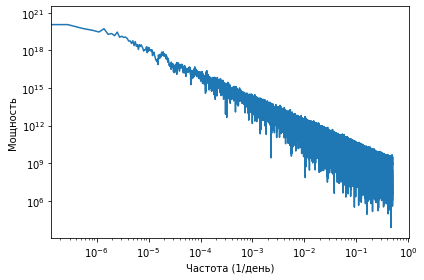

In [35]:
btc_spectrum = btc_wave.make_spectrum()
btc_spectrum.plot_power()
decorate(xlabel='Частота (1/день)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [36]:
btc_spectrum.estimate_slope().slope

-1.8056162277706687

Имеем наклон ~-1.8. Это розовый шум.

# **Упражнение 4.4**

Счетчик Гейгера - прибор для обнаружения радиации. Когда ионизирующи частицы попадают в детектор, на его выходе появляются импульсы тока. Общий выход в определенный момент времени можно смоделировать некоррелированным пуассоновым шумом (UP), где каждая выборка есть случайное число из распределения Пуассона, соответствующее количеству частиц, обнаруженных за интервал измерения.

Напишите класс, называемый *UncorrelatedPoissonNoise*, наследующий *thinkdsp._Noise* и предоставляющий *evaluate*. Следует использовать *Np.random.poisson* для генерации случайный величин из распределения Пуассона. Параметр этой функции *lam* - это среднее число частиц за время каждого интервала. Можно использовать атрибут *amp* для определения *lam*. Например, при чатоте кадров 10 кГц и *amp* 0,001 получится около 10 "щелчков" в секунду.

Сгенерируйте пару секунд UP и прослушайте. Для малых значений *amp*, например 0,001, звук будет как у счетчика Гейгера. При больших значениях он будет похож на белый шум. Вычислите и напечатайте спектр мощности и посмотрите, так ли это.

**Ход работы**

Код класса представлен ниже

In [37]:
class UncorrelatedPoissonNoise(Noise):

    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Как и предлагается в задании сгенерируем данный шум для малых и больших значениях *amp* и посмотрим сопоставимы ли звуки с ожидаемыми.

In [38]:
like_geiger_signal = UncorrelatedPoissonNoise(amp=0.001)
like_geiger_wave = like_geiger_signal.make_wave(duration=2.0, framerate=10000)
like_white_noise_signal = UncorrelatedPoissonNoise(amp=1)
like_white_noise_wave = like_white_noise_signal.make_wave(duration=2.0, framerate=10000)

like_geiger_wave.make_audio()

In [39]:
like_white_noise_wave.make_audio()

Если прослушать звуки, то, действительно, в первом случае услышим что-то похоже на трещание счётчика Гейгера, а во втором - белый шум. Сравним графики и спектры сигналов.

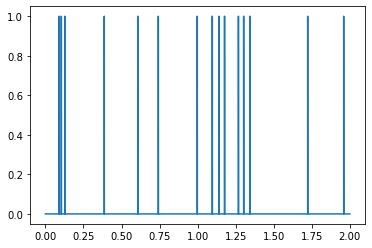

In [40]:
like_geiger_wave.plot()

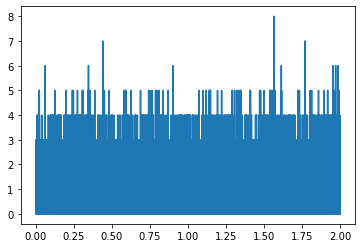

In [41]:
like_white_noise_wave.plot()

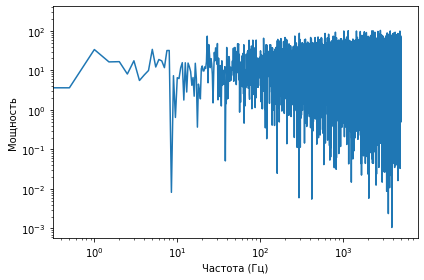

In [42]:
like_geiger_spectrum = like_geiger_wave.make_spectrum()
like_geiger_spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [43]:
like_geiger_spectrum.estimate_slope().slope

-0.009838526487757536

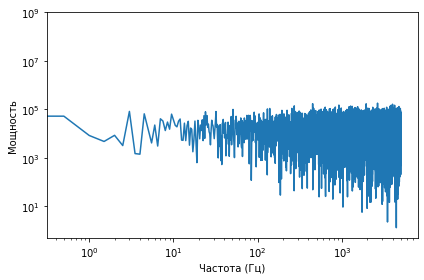

In [44]:
like_white_noise_spectrum = like_white_noise_wave.make_spectrum()
like_white_noise_spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [45]:
like_white_noise_spectrum.estimate_slope().slope

0.001661093033992839

Как мы видим из полученных данных оба сигнала имеют уклон ~0, в связи с чем их можно считать белым шумом.

# **Упражнение 4.5**

В этой главе алгоритм для генерации розового шума концептуально простой, но затратный. Существет более эффективные варианты, например алгоритм Voss-McCartney. Изучите этот способ, реализуйте его, вычислите спектр результата и убедитесь, что соотношения между мощностью и частотой соответсвующие.

**Ход работы**

Составленный алгоритм представлен ниже.

In [46]:
def generate_pink_noise(rows, columns=16):
    array = np.empty((rows, columns))
    array.fill(np.nan)
    array[0, :] = np.random.random(columns)
    array[:, 0] = np.random.random(rows)

    cols = np.random.geometric(0.5, rows)
    cols[cols >= columns] = 0
    new_rows = np.random.randint(rows, size=rows)
    array[new_rows, cols] = np.random.random(rows)

    data = pd.DataFrame(array)
    data.fillna(method='ffill', axis=0, inplace=True)
    total = data.sum(axis=1)

    return total.values

Проверим его на примере с 12000 значениями

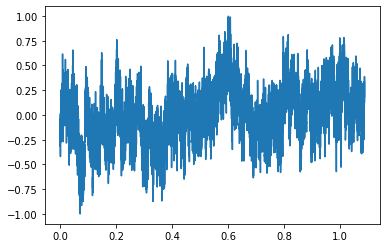

In [47]:
ys = generate_pink_noise(12000)
wave = Wave(ys)
wave.unbias()
wave.normalize()
wave.plot()

In [48]:
wave.make_audio()

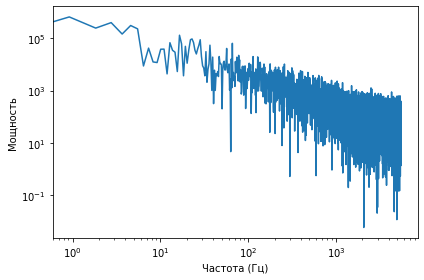

In [49]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [50]:
spectrum.estimate_slope().slope

-1.0316505893770083

Как мы видим уклон близок к -1, а это значит, что у нас получился розовый шум.